# Working with GOES Imagery

In [1]:
import datetime
import cv2 as cv

import numpy as np
import tempfile

from google.cloud import bigquery, storage

from pycontrails.datalib import goes
from pycontrails.physics import units

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as ani
from matplotlib.artist import Artist
from matplotlib.image import AxesImage

import cartopy.img_transform as cimg
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pyorbital.orbital import A as EARTH_RADIUS
from pyorbital.orbital import get_observer_look

## Introduction

This notebook will show how to render GOES images and overlay inforamtion from other data sources on to the GOES images.

One important concept to keep in mind when working with satellite imagery is the effects of the perspective of the satellite.
Contrails and cloud tops be has high as 40,000 ft above the ground. 
Further away from the center of the satellite image, this will cause the cloud tops to appear shifted relative to their true latitude and longitude.
We will provide example code here to demonstrate how to correct for this, which is often referred to as parallax correction in the remote sensing community.
For more discussion of parallax correction and GOES see [this website](https://cimss.ssec.wisc.edu/goes/webapps/parallax/overview.html).
An excellent overview of perspective and projection in computer vision can be found [here](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect5.pdf).

In addition to the standard pycontrails library, the parallax correction code in this notebook also requires the package [pyorbital](https://github.com/pytroll/pyorbital), which can be installed by uncommenting the following line (leaving the leading `!`) or using your standard package manager.

In [2]:
#!pip install pyorbital

## Code to perform parallax correction

In [3]:
def lonlat2xyz(lon, lat):
    """Convert lon lat to cartesian.
    """
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

def xyz2lonlat(x, y, z, asin=False):
    """Convert cartesian to lon lat.
    """
    lon = np.rad2deg(np.arctan2(y, x))
    if asin:
        lat = np.rad2deg(np.arcsin(z))
    else:
        lat = np.rad2deg(np.arctan2(z, np.sqrt(x ** 2 + y ** 2)))
    return lon, lat
    
def _get_satellite_elevation(sat_lon, sat_lat, sat_alt, lon, lat):
    """Get satellite elevation
    """
    placeholder_date = datetime.datetime(2000, 1, 1)  # ignored for geospatial
    (_, elevation) = get_observer_look(
            sat_lon, sat_lat, sat_alt/1e3,  # m → km (wanted by get_observer_look)
            placeholder_date, lon, lat, 0)
    return elevation

def _get_parallax_shift_xyz(sat_lon, sat_lat, sat_alt, lon, lat, parallax_distance, correct=True):
    """Calculate the parallax shift in cartesian coordinates.

    Returns:
        Parallax shift in cartesian coordinates in meters.
    """
    sat_xyz = np.hstack(lonlat2xyz(sat_lon, sat_lat)) * sat_alt
    cth_xyz = np.stack(lonlat2xyz(lon, lat), axis=-1) * EARTH_RADIUS*1e3  # km → m
    delta_xyz = cth_xyz - sat_xyz
    sat_distance = np.sqrt((delta_xyz*delta_xyz).sum(axis=-1))
    dist_shape = delta_xyz.shape[:-1] + (1,)  # force correct array broadcasting
    if correct:
        return cth_xyz - delta_xyz*(parallax_distance/sat_distance).reshape(dist_shape)
    else:
        return cth_xyz + delta_xyz*(parallax_distance/sat_distance).reshape(dist_shape)

def parallax_correct(lon, lat, height, goes_da, correct=True):
    sat_lon = goes_da.attrs['geospatial_lat_lon_extent']['geospatial_lon_center']
    sat_lat = goes_da.attrs['geospatial_lat_lon_extent']['geospatial_lat_center']
    sat_alt = goes_da.attrs['goes_imager_projection']['perspective_point_height']
    
    elevation = _get_satellite_elevation(sat_lon, sat_lat, sat_alt, lon, lat)
    parallax_distance = height / np.sin(np.deg2rad(elevation))
    shifted_xyz = _get_parallax_shift_xyz(
            sat_lon, sat_lat, sat_alt, lon, lat, parallax_distance, correct)
    return xyz2lonlat(shifted_xyz[..., 0], shifted_xyz[..., 1], shifted_xyz[..., 2])

## Pull the app image and associated metadata

In [4]:
goes_handler = goes.GOES(goes.GOESRegion.F)
client = bigquery.Client()
storage_client = storage.Client("contrails-observer")
bucket = storage_client.get_bucket("contrails-observer.appspot.com")
photo_id = 'pAviMIP3wBhP15RSaGzO'

Premature end of JPEG file


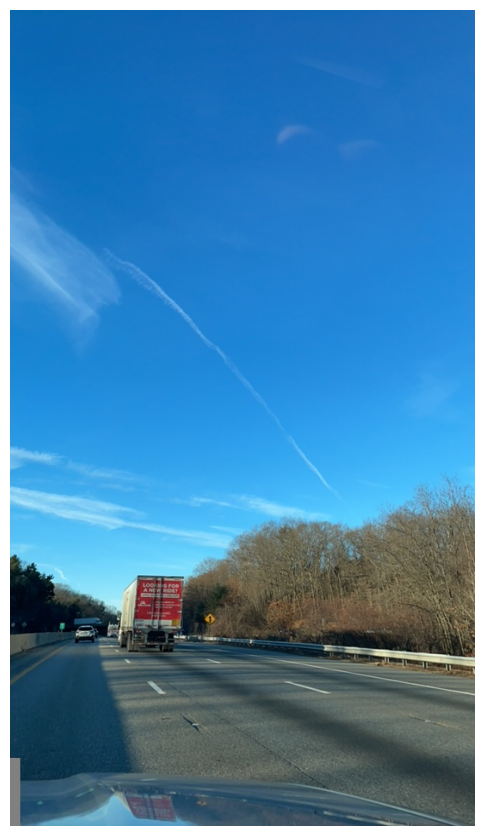

In [5]:
with tempfile.NamedTemporaryFile() as tmp:
    blob = bucket.blob(photo_id)
    blob.download_to_file(tmp)
    fig, ax = plt.subplots(1,figsize=(6,10.6))
    img_color = cv.imread(tmp.name)
    ax.imshow(img_color[...,::-1],aspect='auto')
    ax.set_axis_off()

In [6]:
# Get photo polygons from big query
QUERY = (
    'SELECT timestamp, latitude, longitude, id FROM `contrails-301217.workshop_observerapp.image_metadata`'
    f'WHERE id = "{photo_id}"')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)
assert len(ra) == 1
dt = ra[0].timestamp
latitude = ra[0].latitude
longitude = ra[0].longitude

In [7]:
# Round time up to ten minute interval so it falls on a GOES frame
dt = dt + datetime.timedelta(minutes=10) - datetime.timedelta(minutes=dt.minute % 10, seconds=dt.second,microseconds=dt.microsecond)
tstr = dt.strftime('%Y-%m-%d %H:%M:00')

In [8]:
# Get GOES image and perspective information
da = goes_handler.get(tstr)
rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")

In [9]:
# Get photo polygons from BigQuery
QUERY = (
    'SELECT geometry, id, level FROM `contrails-301217.workshop_observerapp.image_field_of_view`'
    f'WHERE id = "{photo_id}" '
    'LIMIT 100')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

polygons = {}
for row in rows:
    polygons[row.level] = row.geometry

# Manually parse out lat/lon from BigQuery polygons
coord_dict = {}
for lvl in polygons.keys():
    coords_str = [p.split(' ') for p in polygons[lvl][9:-2].split(', ')]
    coords = [[float(lon), float(lat)] for (lon, lat) in coords_str]
    coord_dict[lvl] = coords

In [10]:
# Apply parallax correction
corrected_dict = {}
for lvl in coord_dict.keys():
    height = units.ft_to_m(lvl*100)
    corrected = []
    for lon, lat in coord_dict[lvl]:
        corrected.append(parallax_correct(lon, lat, height, da, False))
    corrected_dict[lvl] = corrected

## Plotting the results

In this example, we plot the location of the image, as well as the polygons that approximate the intersections of each flight level in the frame of view of the camera. The first photo does not account for the perspective of the satellite and is only plotting the raw lat/lon coordinates of the polygons

In [ ]:
# Uncorrected:
dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude)
for lvl in coord_dict.keys():
    ax.add_patch(mpatches.Polygon(xy=coord_dict[lvl], alpha=0.5, transform=dst_crs))
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

_ = ax.set_title("Ignoring Parallax")

In the photo below, the lat/lon locations of the polygon are corrected to account for the perspective of the satellite. Note that the corrected lat/lon values are not in any sense a 'true' location of the polygons, they are only the apparent locations of the polygons from the perspective of the satellite.  Comparing the two sets of images, we can see that the shift in apparent location is rather large!

In [ ]:
# Corrected:
dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude)
for lvl in corrected_dict.keys():
    ax.add_patch(mpatches.Polygon(xy=corrected_dict[lvl], alpha=0.5, transform=dst_crs))
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

_ = ax.set_title("Parallax corrected to FL")

## Get Google Contrail detections and plot them

Now we will show parallax correction in the other direction. 
We will first pull the mask of contrail detections created by Google. 
These masks give the **apparent** location of the contrails.
Finding their actual latitude and longitude is somewhat complicated by the fact that we do not know the actual altitude
of the contrail.  

In [ ]:
# Select all detections from this timestep and that appear within the lat/lon bounds of the GOES image 
# displayed above
QUERY = (
    'SELECT geometry FROM `contrails-301217.workshop_observerapp.google_goes_detections`'
    f'WHERE TIMESTAMP_TRUNC(timestamp,MINUTE) = TIMESTAMP("{tstr}")' 
    f'AND ST_INTERSECTSBOX(geometry, {longitude-2.5}, {latitude-2.5}, {longitude+2.5}, {latitude+2.5})'
)
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)

In [ ]:
# Manually parse out the raw coordinates from the response
raw_lines = []
for row in ra:
    coords_str = [p.split(' ') for p in row[0][11:-2].split(', ')]
    coords = [[float(lon), float(lat)] for (lon, lat) in coords_str]
    raw_lines.append(coords)

# Apply parallax correction - assuming two different altitudes: 30000 and 40000 ft
at_fl400 = []
at_fl300 = []
for line in raw_lines:
    height = units.ft_to_m(40000)
    corrected = []
    for lon, lat in line:
        corrected.append(parallax_correct(lon, lat, height, da, True))
    at_fl400.append(corrected)

    height = units.ft_to_m(30000)
    corrected = []
    for lon, lat in line:
        corrected.append(parallax_correct(lon, lat, height, da, True))
    at_fl300.append(corrected)

In [ ]:
#Now plot these detections on our image

dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude)

for i,line in enumerate(raw_lines):
    la = np.array(line)
    if not i:
        ax.plot(la[:,0],la[:,1], 'b', label='Raw detections')
    else:
        ax.plot(la[:,0],la[:,1], 'b')

for i, line in enumerate(at_fl400):
    la = np.array(line)
    if not i:
        ax.plot(la[:,0],la[:,1], 'r', label='FL400')
    else:
        ax.plot(la[:,0],la[:,1], 'r')

for i, line in enumerate(at_fl300):
    la = np.array(line)
    if not i:
        ax.plot(la[:,0],la[:,1], 'k', label='FL300')
    else:
        ax.plot(la[:,0],la[:,1], 'k')
    
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

_ = ax.legend()

In this image, the raw detections are show in blue. 
These lines are what should be intersected with the parallax corrected polygons in the previous photo as they give the apparent location of the contrail from the perspective of the satellite.
The corrected locations are show in red (assuming an altitude of 40000 ft) and black (assuming an altitude of 30000 ft).  These are the actual locations of the contrails relative to the surface of the earth, and are the locations that would correspond to the values output CoCiP.

None of the detections overlap with the perspective of the image captured with the app. This is not too surprising as the contrail show in the image is rather narrow.

## Creating a video from GOES Mesoscale Imagery

Here we manually selected a photo that falls within the GOES M1 mesoscale region

In [ ]:
goes_handler = goes.GOES(goes.GOESRegion.M1)
photo_id = 'attwpX2Q1k2DpM5sR0BD'
with tempfile.NamedTemporaryFile() as tmp:
    blob = bucket.blob(photo_id)
    blob.download_to_file(tmp)
    fig, ax = plt.subplots(1,figsize=(10.6,6))
    img_color = cv.imread(tmp.name)
    ax.imshow(cv.rotate(img_color[...,::-1], 2),aspect='auto')
    ax.set_axis_off()

In [ ]:
# Get photo polygons from big query
QUERY = (
    'SELECT timestamp, latitude, longitude, id FROM `contrails-301217.workshop_observerapp.image_metadata`'
    f'WHERE id = "{photo_id}"')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)
assert len(ra) == 1
dt = ra[0].timestamp
latitude = ra[0].latitude
longitude = ra[0].longitude

In [ ]:
# Round time up to minute interval so it falls on a GOES frame
dt = dt - datetime.timedelta(seconds=dt.second,microseconds=dt.microsecond)
tstr = dt.strftime('%Y-%m-%d %H:%M:00')

# Get GOES image and transform info
da = goes_handler.get(tstr)
rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")

In [ ]:
# Get photo polygons from big query
QUERY = (
    'SELECT geometry, id, level FROM `contrails-301217.workshop_observerapp.image_field_of_view`'
    f'WHERE id = "{photo_id}" '
    'LIMIT 100')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

polygons = {}
for row in rows:
    polygons[row.level] = row.geometry

# Manually parse out lat/lon from BigQuery polygons
coord_dict = {}
for lvl in polygons.keys():
    coords_str = [p.split(' ') for p in polygons[lvl][9:-2].split(', ')]
    coords = [[float(lon), float(lat)] for (lon, lat) in coords_str]
    coord_dict[lvl] = coords

# Apply parallax correction
corrected_dict = {}
for lvl in coord_dict.keys():
    height = units.ft_to_m(lvl*100)
    corrected = []
    for lon, lat in coord_dict[lvl]:
        corrected.append(parallax_correct(lon, lat, height, da, False))
    corrected_dict[lvl] = corrected

In [ ]:
# Corrected:
dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude, c='k')
for lvl in corrected_dict.keys():
    ax.add_patch(mpatches.Polygon(xy=corrected_dict[lvl], fill=None, alpha=0.33, transform=dst_crs))
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

_ = ax.set_title("Parallax corrected to FL")

### Code to construct animation from a series of Cartopy images
Unfortunately, it is not so straight-forward to create an animation from a series of `GeoAxis` objects.
One way to do this, would be to create each frame of the animation separately, save them off as bitmap or jpeg images
and then recombine them with a tool like `PIL` or `ffmpeg`.  
Here, we show an alternative approach, using `matplotlib`'s built in `FuncAnimation`.  We need to reconstruct the logic of the `imshow` function to make this work.

In [ ]:
def geoaxis_imshow(
    ax: GeoAxes,
    arr: np.ndarray,
    source_proj: ccrs.Geostationary,
    source_extent: np.ndarray,
    target_res: tuple[int, int],
    **kwargs,
) -> AxesImage:
    if arr.ndim not in [2, 3]:
        raise ValueError("Parameter `arr` must be 2 or 3 dimensional.")

    # If ax currently doesn't have an image (e.g. on first frame), create one.
    if not (ims := ax.get_images()):
        return ax.imshow(
            arr,
            extent=source_extent,
            transform=source_proj,
            regrid_shape=target_res,
            **kwargs,
        )

    target_proj = ax.projection
    arr = arr[::-1]

    arr, _ = cimg.warp_array(
        arr,
        source_proj=source_proj,
        source_extent=source_extent,
        target_proj=target_proj,
        target_res=target_res,
        target_extent=ax.get_extent(),
        mask_extrapolated=True,
    )

    # Simplified version of logic in `ax.imshow`
    if arr.ndim == 3:
        if isinstance(arr, np.ma.MaskedArray):
            alpha = ~arr.mask.any(axis=2)
        else:
            alpha = np.ones_like(arr[:, :, 0])
        arr = np.dstack([arr.data, alpha])

    # Confirming ax contains a single image.
    (im,) = ims
    im.set_data(arr)
    return im

def anim_func_overlay(date, axes):
    artists = []
    
    # Get GOES image and transform info
    da = goes_handler.get(date)
    rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")
    
    im = geoaxis_imshow(axes, rgb, src_crs, src_extent,(600,1000))
    artists.append(im)
            
    return artists

In [ ]:
fig = plt.figure(figsize=(16,12))
pc = ccrs.PlateCarree()
ax1 = fig.add_subplot(111, projection=pc, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

# We can draw the static features we want on the image once
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

ax1.scatter(longitude,latitude)
for lvl in corrected_dict.keys():
    ax1.add_patch(mpatches.Polygon(xy=corrected_dict[lvl], fill=None, alpha=0.33, transform=dst_crs))

# Pull frames from ten minutes before and after
dates = []
dt -= datetime.timedelta(minutes=5)
for i in range(11):
    dates.append(dt.strftime('%Y-%m-%d %H:%M:00'))
    dt += datetime.timedelta(minutes=1)

anim = ani.FuncAnimation(
    fig=fig,
    func=anim_func_overlay,
    frames=dates,
    fargs=[ax1],
    init_func=lambda: None,
    interval=100,
    blit=False)

anim.save("goes_overlay.mp4",dpi=100)

plt.close()